# FlauBert classification
Ce notebook vise à évaluer les performances d'un modèle FlauBERT pré-entrainé sur le corpus OSCAR pour la classification de textes en français. Le modèle est chargé depuis le hub HuggingFace et la dernière couche est fine-tunée sur un jeu de données de classification de textes.

In [1]:
# ---------------------------- PREPARING NOTEBOOK ---------------------------- #
# Autoreload
%load_ext autoreload
%autoreload 2

# Random seed
import numpy as np
np.random.seed(42)

# External modules
import os
from IPython.display import display, Markdown, Latex, clear_output
from tqdm import notebook as tqdm

# Set global log level
import logging
logging.basicConfig(level=logging.INFO)

# Define PWD as the current git repository
import git
repo = git.Repo('.', search_parent_directories=True)
pwd = repo.working_dir
os.chdir(pwd)

## Pretrained FlauBert

Pour notre classification Zero-shot, nous allon utiliser le modèle [FlauBert](https://huggingface.co/lincoln/flaubert-mlsum-topic-classification?text=La+bourse+de+paris+en+forte+baisse+apr%C3%A8s+que+des+canards+ont+envahit+le+parlement.) qui classifie les textes en 10 catégories :
- **Economie**: economie, argent, emploi, entreprises, economie-francaise, immobilier, crise-financiere, evasion-fiscale, economie-mondiale, m-voiture, smart-cities, automobile, logement, flottes-d-entreprise, import, crise-de-l-euro, guide-des-impots, le-club-de-l-economie, telephonie-mobile
- **Opinion**: idees, les-decodeurs, tribunes
- **Politique**: politique, election-presidentielle-2012, election-presidentielle-2017, elections-americaines, municipales, referendum-sur-le-brexit, elections-legislatives-2017, elections-regionales, donald-trump, elections-regionales-2015, europeennes-2014, elections-cantonales-2011, primaire-parti-socialiste, gouvernement-philippe, elections-departementales-2015, chroniques-de-la-presidence-trump, primaire-de-la-gauche, la-republique-en-marche, elections-americaines-mi-mandat-2018, elections, elections-italiennes, elections-senatoriales
- **Societe**: societe, sante, attaques-a-paris, immigration-et-diversite, religions, medecine, francaises-francais, mobilite
- **Culture**: televisions-radio, musiques, festival, arts, scenes, festival-de-cannes, mode, bande-dessinee, architecture, vins, photo, m-mode, fashion-week, les-recettes-du-monde, tele-zapping, critique-litteraire, festival-d-avignon, m-gastronomie-le-lieu, les-enfants-akira, gastronomie, culture, livres, cinema, actualite-medias, blog, m-gastronomie
- **Sport**: sport, football, jeux-olympiques, ligue-1, tennis, coupe-du-monde, mondial-2018, rugby, euro-2016, jeux-olympiques-rio-2016, cyclisme, ligue-des-champions, basket, roland-garros, athletisme, tour-de-france, euro2012, jeux-olympiques-pyeongchang-2018, coupe-du-monde-rugby, formule-1, voile, top-14, ski, handball, sports-mecaniques, sports-de-combat, blog-du-tour-de-france, sport-et-societe, sports-de-glisse, tournoi-des-6-nations
- **Environement**: planete, climat, biodiversite, pollution, energies, cop21
- **Technologie**: pixels, technologies, sciences, cosmos, la-france-connectee, trajectoires-digitales
- **Education**: campus, education, bac-lycee, enseignement-superieur, ecole-primaire-et-secondaire, o21, orientation-scolaire, brevet-college
- **Justice**: police-justice, panama-papers, affaire-penelope-fillon, documents-wikileaks, enquetes, paradise-papers

In [3]:
# -------------------------------- LOAD MODEL -------------------------------- #
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("lincoln/flaubert-mlsum-topic-classification")
model = AutoModelForSequenceClassification.from_pretrained(
    "lincoln/flaubert-mlsum-topic-classification"
)

`do_lowercase_and_remove_accent` is passed as a keyword argument, but this won't do anything. `FlaubertTokenizer` will always set it to `False`.


In [4]:
# ------------------------------- LOAD DATASETS ------------------------------ #
import pandas as pd

dataset_path = os.path.join(pwd, "results", "topic_classification", "DataPreparation")

train_dataset = pd.read_csv(os.path.join(dataset_path, "train.csv"))
test_dataset = pd.read_csv(os.path.join(dataset_path, "test.csv"))
full_dataset = pd.concat([train_dataset, test_dataset])

In [5]:
# ----------------------- COMPUTE FLAUBERT PREDICTIONS ----------------------- #
import torch
from transformers import AutoConfig
import pandas as pd
from tqdm import tqdm_notebook


def batch_predict(inputs, model, labels, batch_size=256):
    predictions = []
    for i in tqdm_notebook(range(0, len(inputs["input_ids"]), batch_size)):
        batch = {k: v[i : i + batch_size] for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**batch)
        predictions.extend(outputs.logits.cpu().numpy())
    return pd.DataFrame(predictions, columns=labels.values())


# Encode all texts
train_inputs = tokenizer(
    train_dataset["text"].tolist(),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512,
)

test_inputs = tokenizer(
    test_dataset["text"].tolist(),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512,
)

# Move inputs to GPU if available
if torch.cuda.is_available():
    train_inputs = {name: tensor.to("cuda") for name, tensor in train_inputs.items()}
    test_inputs = {name: tensor.to("cuda") for name, tensor in test_inputs.items()}
    model = model.to("cuda")

# Load model configuration
config = AutoConfig.from_pretrained("lincoln/flaubert-mlsum-topic-classification")

# Get labels
labels = config.id2label

# Create a dataframe with the predictions
train_predictions = batch_predict(train_inputs, model, labels)
test_predictions = batch_predict(test_inputs, model, labels)

# Free GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

/tmp/ipykernel_13474/4201756029.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, len(inputs["input_ids"]), batch_size)):


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
# Save predictions
path = os.path.join(pwd, "scratch", "topic_classification", "ZeroShot")
if not os.path.exists(path):
    os.makedirs(path)
train_predictions.to_csv(os.path.join(path, "flaubert_logits_train.csv"), index=False)
test_predictions.to_csv(os.path.join(path, "flaubert_logits_test.csv"), index=False)

### Adapting categories

Now that we have the labels predicted by the [FlauBert model](https://huggingface.co/lincoln/flaubert-mlsum-topic-classification?text=La+bourse+de+paris+en+forte+baisse+apr%C3%A8s+que+de+canards+have+invaded+the+parliament.), we need to adapt them to the categories in the **Zeeguu** dataset.

To do this, we will train a simple linear model to carry out the transformation.

In [16]:
# -------------------- ADAPT PREDICTIONS TO ZEEGUU DATASET ------------------- #
from sklearn.linear_model import LogisticRegression

# Créez une instance de LogisticRegression
logistic_regression = LogisticRegression(multi_class="multinomial", solver="lbfgs")

# Entraînez le modèle sur vos données
logistic_regression.fit(train_predictions, train_dataset["topic"].tolist())

# Prédisez les classes pour l'ensemble de test
predictions_logits = logistic_regression.predict_proba(test_predictions)
classes = logistic_regression.classes_

/home/lopilo24/UNIL/Lingorank_LLM/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
# ---------------------------- DISPLAY PREDICTIONS --------------------------- #
df = pd.DataFrame(
    {
        "sequence": test_dataset["text"],
        "labels": np.array(classes)[np.argsort(-predictions_logits, axis=1)].tolist(),
        "scores": predictions_logits.tolist(),
        "label": test_dataset["topic"],
    }
)

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "flaubert_predictions.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
df.to_csv(path)

df

,sequence,labels,scores,label
0,Quand Hollywood rencontre le football gallois\...,"[Sport, Travel, Health, World, Culture, Busine...","[0.010432399348038099, 0.011404023545181169, 0...",Science
1,Emmanuel Mayonnade (Metz) : « Ne pas être pris...,"[Sport, World, Health, Travel, Business, Cultu...","[0.0075680864584747225, 0.005911216812268455, ...",Sport
2,"Tennis: 2021, l'année où Djokovic et Nadal peu...","[Sport, Travel, Health, World, Business, Cultu...","[0.005964905313440089, 0.00441407141145177, 0....",Sport
3,Répression en Iran : l’Union européenne adopte...,"[World, Culture, Travel, Politics, Health, Spo...","[0.01709365763047918, 0.2262356210947576, 0.00...",World
4,"Kendji Girac, la voix de ses maîtres\n\nb""VID\...","[Music, Culture, Travel, Food, Health, Politic...","[0.0001782222319392453, 0.3620409585534477, 0....",Music
...,...,...,...,...
1946,"Aux États-Unis, des manifestants tentent d'aba...","[Travel, Culture, Science, Health, World, Spor...","[0.019597010398322026, 0.2033854869508079, 0.0...",Culture
1947,"Hôtel Transylvanie 3 : vampires & Cie !\n\nb""P...","[Culture, Music, Sport, World, Travel, Science...","[0.0037869872309508374, 0.7078513049703617, 0....",Culture
1948,"Le poème du lundi : aujourd'hui, «des sportifs...","[Culture, Travel, Music, Health, Food, Science...","[0.0019254692964640254, 0.5280932155359533, 0....",Culture
1949,"Lundi poésie : aujourd'hui, quand Roubaud rééc...","[Music, Culture, Travel, Food, Health, Sport, ...","[0.00016427720946049238, 0.4312516786286215, 0...",Culture


,accuracy@1,accuracy@3,accuracy@5
Food,0.095238,0.261905,0.666667
Business,0.107143,0.285714,0.607143
Science,0.276596,0.716312,0.829787
Music,0.387755,0.925170,0.945578
Travel,0.477157,0.903553,0.974619
World,0.491935,0.814516,0.919355
Technology,0.544304,0.683544,0.797468
Health,0.606195,0.845133,0.986726
Culture,0.630662,0.864111,0.944251
Politics,0.672131,0.803279,0.868852


,accuracy,precision,recall,f1
Flaubert-pretrained,0.61917,0.61917,0.61917,0.61917


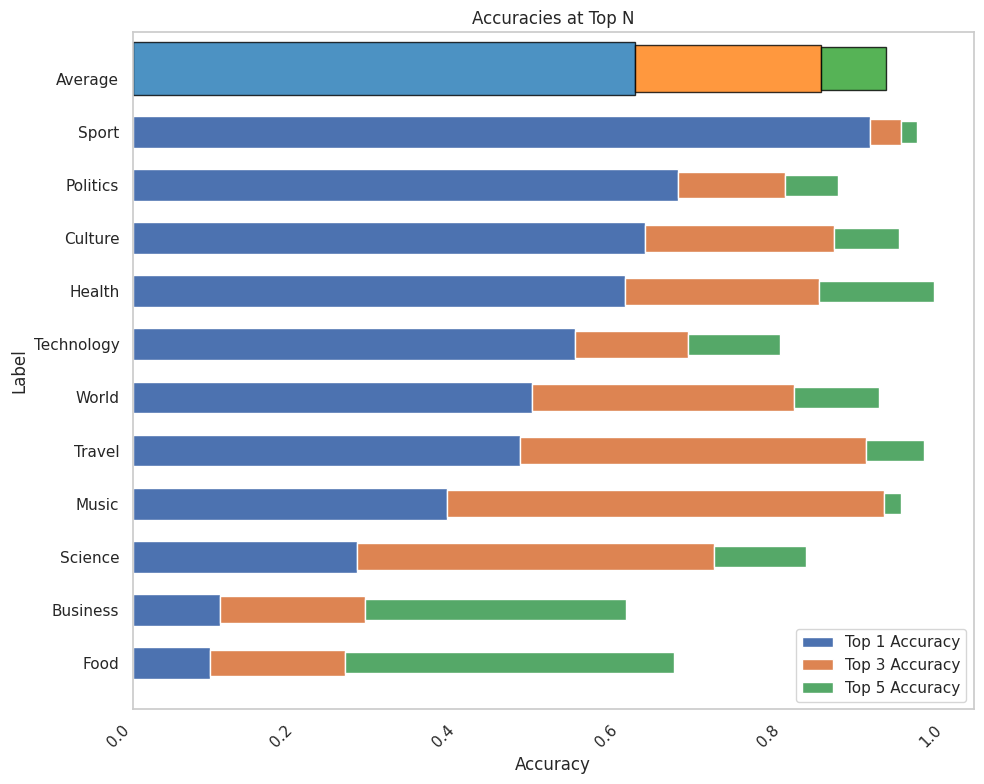

In [4]:
# ----------------------------- DISPLAY METRICS ------------------------------ #
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

result = pd.read_csv(
    os.path.join(
        pwd,
        "results",
        "topic_classification",
        "ZeroShot",
        "flaubert_predictions.csv",
    )
)
result["labels"] = result["labels"].apply(lambda x: eval(x))
result["scores"] = result["scores"].apply(lambda x: eval(x))


def is_in_top_n(label: str, n: int = 1) -> pd.Series:
    return result[result["label"] == label]["labels"].apply(lambda x: label in x[:n])


metrics = {}
for label in result["label"].unique():
    metrics[label] = {
        "accuracy@1": is_in_top_n(label, 1).mean(),
        "accuracy@3": is_in_top_n(label, 3).mean(),
        "accuracy@5": is_in_top_n(label, 5).mean(),
    }
metrics["Average"] = {
    "accuracy@1": result.apply(lambda x: x["label"] in x["labels"][:1], axis=1).mean(),
    "accuracy@3": result.apply(lambda x: x["label"] in x["labels"][:3], axis=1).mean(),
    "accuracy@5": result.apply(lambda x: x["label"] in x["labels"][:5], axis=1).mean(),
}

metrics = pd.DataFrame(metrics).T
metrics = metrics.sort_values("accuracy@1", ascending=True)

# Move Average row to the top
metrics = pd.concat([metrics.drop("Average"), metrics.loc[["Average"]]])

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "flaubert_metrics.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
metrics.to_csv(path)

display(metrics)

# Calculate precision, recall and f1-score
precision = precision_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
recall = recall_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
f1 = f1_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
classification_metrics = pd.DataFrame(
    {
        "accuracy": [metrics.loc["Average", "accuracy@1"]],
        "precision": [precision],
        "recall": [recall],
        "f1": [f1],
    },
    index=["Flaubert-pretrained"],
)

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "Flaubert-pretrained_classification_metrics.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
classification_metrics.to_csv(path)

display(classification_metrics)

import matplotlib.pyplot as plt
import seaborn as sns

# Assurez-vous que le DataFrame 'metrics' est déjà créé et trié par 'accuracy@1'
# metrics.sort_values("accuracy@1", ascending=False)

# Réinitialiser l'index pour pouvoir utiliser la colonne des labels dans le graphique
metrics.reset_index(inplace=True)
metrics.rename(columns={"index": "Label"}, inplace=True)

# Nous utilisons seaborn pour un style de graphique amélioré
sns.set_theme(style="whitegrid")

# La taille du graphique peut être ajustée pour mieux s'adapter à vos données
plt.figure(figsize=(10, 8))

# Création d'un graphique à barres empilées
# bottom paramètre spécifie où la barre commence, donc nous empilons en additionnant la précision précédente
plt.barh(metrics["Label"], metrics["accuracy@1"], label="Top 1 Accuracy", height=0.6)
plt.barh(
    metrics["Label"],
    metrics["accuracy@3"] - metrics["accuracy@1"],
    label="Top 3 Accuracy",
    height=0.5,
    left=metrics["accuracy@1"],
)
plt.barh(
    metrics["Label"],
    metrics["accuracy@5"] - metrics["accuracy@3"],
    label="Top 5 Accuracy",
    height=0.4,
    left=metrics["accuracy@3"],
)

# Titre du graphique et étiquettes des axes
plt.title("Accuracies at Top N")
plt.xlabel("Accuracy")
plt.ylabel("Label")

# Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité si nécessaire
plt.xticks(rotation=45, ha="right")

# Ajout d'une légende
plt.legend()

# Utilisez plt.tight_layout() si vous constatez que les étiquettes sont coupées dans la sortie finale
plt.tight_layout()

# Remove grid
plt.grid(False)

# Give specific color to first bar
plt.gca().get_children()[11].set(
    color="#1f77b4", alpha=0.8, edgecolor="black", height=1
)
plt.gca().get_children()[23].set(
    color="#ff7f0e", alpha=0.8, edgecolor="black", height=0.9
)
plt.gca().get_children()[35].set(
    color="#2ca02c", alpha=0.8, edgecolor="black", height=0.8
)

# Affichage du graphique
plt.show()

accuracy                                                      0.61917
recall                                                        0.61917
precision                                                    0.619566
f1_score                                                     0.609267
confusion_matrix    [[0.10714285714285714, 0.07142857142857142, 0....
dtype: object

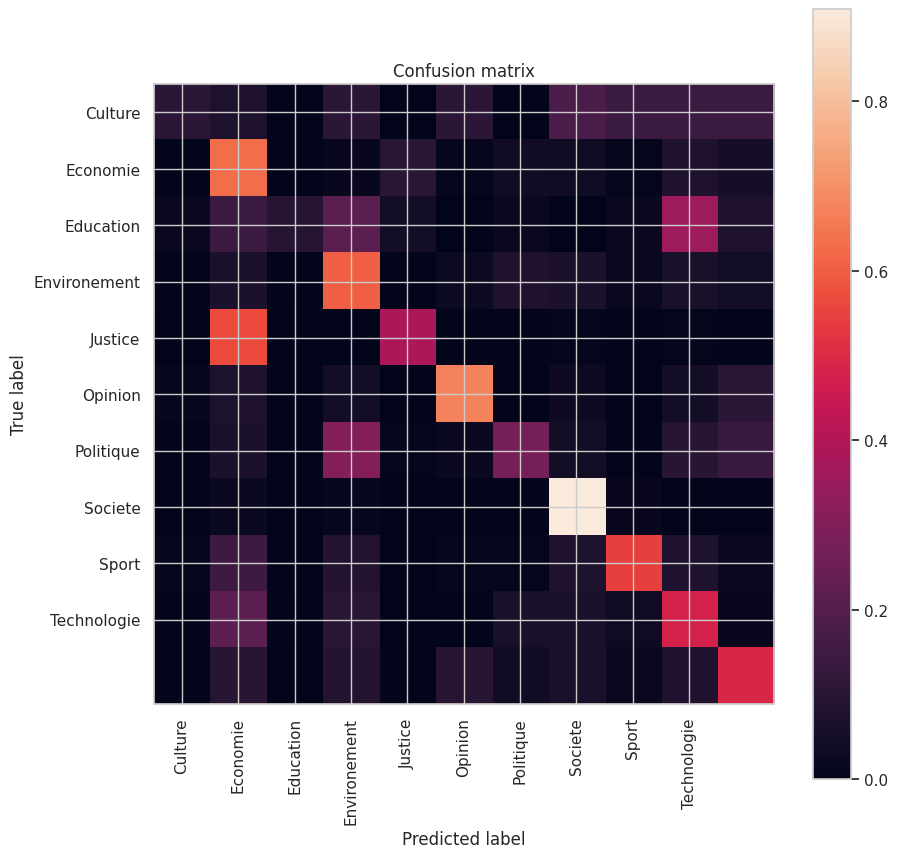

In [26]:
import modcell
from matplotlib import pyplot as plt
import numpy as np

import notebooks.topic_classification.a_DataPreparation as dp

metrics = dp.compute_metrics(predictions, test_dataset["topic"].tolist())

# Display metrics
display(metrics)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(metrics["confusion_matrix"])
plt.colorbar()
plt.xticks(range(len(labels)), labels.values(), rotation=90)
plt.yticks(range(len(labels)), labels.values())
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show()

## mDeBERTa-v3

[mDeBERTa-v3](https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7) est un modèle multilangue préentrainé qui peut-être utilisé pour de la classification zero-shot. Nous allons évaluer ses performances sur notre jeu de données.

In [73]:
import pandas as pd
from transformers import pipeline

# Charger le modèle zero-shot
classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
    device="cuda",
)

test_dataset = pd.read_csv(
    os.path.join(pwd, "results", "topic_classification", "DataPreparation", "test.csv")
)

labels = test_dataset["topic"].unique().tolist()

# Diviser les données en lots pour les prédictions par batch
batch_size = 64
batches = [
    test_dataset[i : i + batch_size]
    for i in range(0, test_dataset.shape[0], batch_size)
]

# Effectuer des prédictions par batch
predictions = []
for batch in batches:
    batch_texts = batch["text"].tolist()
    batch_predictions = classifier(
        batch_texts, labels, multi_label=False, batch_size=batch_size
    )
    predictions.extend(batch_predictions)

# Create results dataframe
result = pd.DataFrame(predictions)
result["label"] = test_dataset["topic"].tolist()

# Save results
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "mDeBERTa-v3-base-mnli-xnli_predictions.csv",
)
## Create folder if it does not exist
os.makedirs(os.path.dirname(path), exist_ok=True)
result.to_csv(path, index=False)

result

/home/lopilo24/UNIL/Lingo_other_branch/Lingorank_LLM/.venv/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,sequence,labels,scores,label
0,Quand Hollywood rencontre le football gallois\...,"[Travel, Technology, Business, Sport, World, C...","[0.11943895369768143, 0.11629103869199753, 0.0...",Science
1,Emmanuel Mayonnade (Metz) : « Ne pas être pris...,"[Travel, Politics, Business, Sport, Health, Wo...","[0.5864251852035522, 0.06865323334932327, 0.06...",Sport
2,"Tennis: 2021, l'année où Djokovic et Nadal peu...","[Sport, World, Travel, Politics, Business, Sci...","[0.40880683064460754, 0.14321117103099823, 0.1...",Sport
3,Répression en Iran : l’Union européenne adopte...,"[Technology, Politics, World, Food, Music, Sci...","[0.13139095902442932, 0.12900695204734802, 0.1...",World
4,"Kendji Girac, la voix de ses maîtres\n\nb""VID\...","[Music, Culture, World, Sport, Food, Business,...","[0.21788708865642548, 0.10540976375341415, 0.0...",Music
...,...,...,...,...
1946,"Aux États-Unis, des manifestants tentent d'aba...","[World, Culture, Politics, Travel, Business, S...","[0.11684475094079971, 0.1111300140619278, 0.10...",Culture
1947,"Hôtel Transylvanie 3 : vampires & Cie !\n\nb""P...","[Travel, Sport, Business, Culture, Music, Worl...","[0.1312291920185089, 0.10815386474132538, 0.09...",Culture
1948,"Le poème du lundi : aujourd'hui, «des sportifs...","[Health, Sport, World, Culture, Music, Technol...","[0.7081612944602966, 0.12168708443641663, 0.11...",Culture
1949,"Lundi poésie : aujourd'hui, quand Roubaud rééc...","[World, Culture, Food, Health, Music, Travel, ...","[0.10600012540817261, 0.10424930602312088, 0.1...",Culture


,accuracy@1,accuracy@3,accuracy@5
Science,0.099291,0.276596,0.468085
World,0.153226,0.725806,0.862903
Business,0.250000,0.571429,0.928571
Culture,0.275261,0.745645,0.919861
Technology,0.367089,0.746835,0.898734
Health,0.424779,0.778761,0.880531
Sport,0.439068,0.795699,0.915771
Travel,0.492386,0.837563,0.954315
Food,0.547619,0.857143,0.976190
Music,0.700680,0.952381,0.979592


,accuracy,precision,recall,f1
mDeBERTa-v3-base-mnli-xnli,0.419272,0.419272,0.419272,0.419272


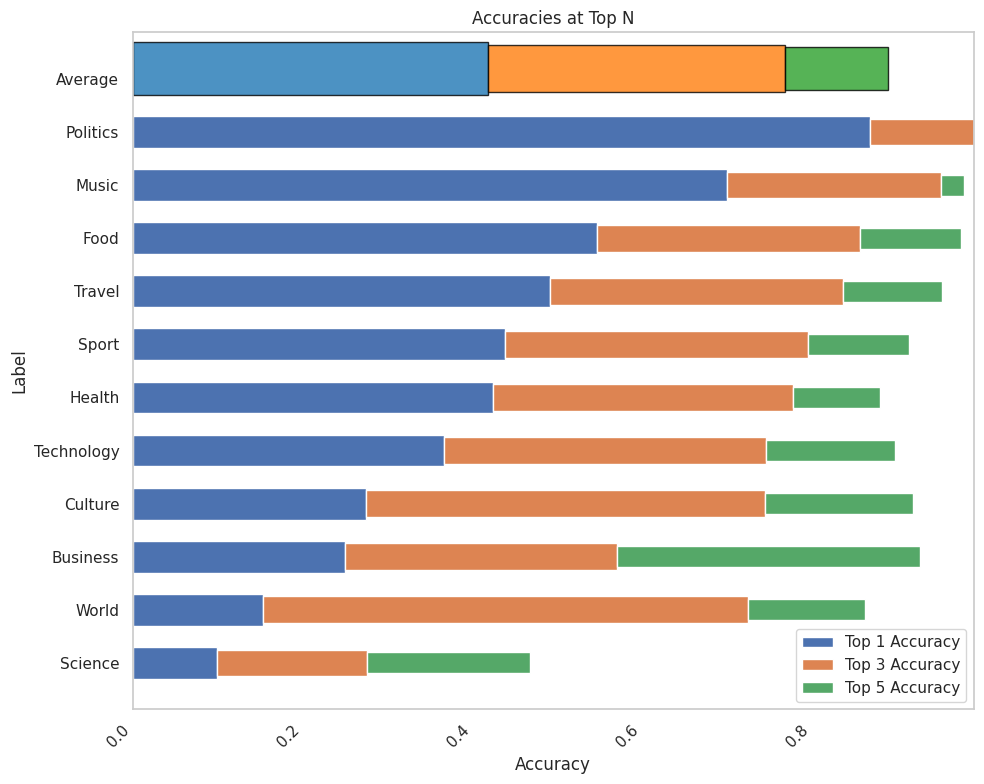

In [5]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

result = pd.read_csv(
    os.path.join(
        pwd,
        "results",
        "topic_classification",
        "ZeroShot",
        "mDeBERTa-v3-base-mnli-xnli_predictions.csv",
    ),
    sep=",",
    index_col=None,
    header=0,
)
result["labels"] = result["labels"].apply(eval)
result["scores"] = result["scores"].apply(eval)


def is_in_top_n(label: str, n: int = 1) -> pd.Series:
    return result[result["label"] == label]["labels"].apply(lambda x: label in x[:n])


metrics = {}
for label in result["label"].unique():
    metrics[label] = {
        "accuracy@1": is_in_top_n(label, 1).mean(),
        "accuracy@3": is_in_top_n(label, 3).mean(),
        "accuracy@5": is_in_top_n(label, 5).mean(),
    }
metrics["Average"] = {
    "accuracy@1": result.apply(lambda x: x["label"] in x["labels"][:1], axis=1).mean(),
    "accuracy@3": result.apply(lambda x: x["label"] in x["labels"][:3], axis=1).mean(),
    "accuracy@5": result.apply(lambda x: x["label"] in x["labels"][:5], axis=1).mean(),
}

metrics = pd.DataFrame(metrics).T
metrics = metrics.sort_values("accuracy@1", ascending=True)

# Move Average row to the top
metrics = pd.concat([metrics.drop("Average"), metrics.loc[["Average"]]])

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "mDeBERTa-v3-base-mnli-xnli_metrics.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
metrics.to_csv(path)

display(metrics)

# Calculate precision, recall and f1-score
precision = precision_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
recall = recall_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
f1 = f1_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
classification_metrics = pd.DataFrame(
    {
        "accuracy": [metrics.loc["Average", "accuracy@1"]],
        "precision": [precision],
        "recall": [recall],
        "f1": [f1],
    },
    index=["mDeBERTa-v3-base-mnli-xnli"],
)

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "mDeBERTa-v3-base-mnli-xnli_classification_metrics.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
classification_metrics.to_csv(path)

display(classification_metrics)

import matplotlib.pyplot as plt
import seaborn as sns

# Assurez-vous que le DataFrame 'metrics' est déjà créé et trié par 'accuracy@1'
# metrics.sort_values("accuracy@1", ascending=False)

# Réinitialiser l'index pour pouvoir utiliser la colonne des labels dans le graphique
metrics.reset_index(inplace=True)
metrics.rename(columns={"index": "Label"}, inplace=True)

# Nous utilisons seaborn pour un style de graphique amélioré
sns.set_theme(style="whitegrid")

# La taille du graphique peut être ajustée pour mieux s'adapter à vos données
plt.figure(figsize=(10, 8))

# Création d'un graphique à barres empilées
# bottom paramètre spécifie où la barre commence, donc nous empilons en additionnant la précision précédente
plt.barh(metrics["Label"], metrics["accuracy@1"], label="Top 1 Accuracy", height=0.6)
plt.barh(
    metrics["Label"],
    metrics["accuracy@3"] - metrics["accuracy@1"],
    label="Top 3 Accuracy",
    height=0.5,
    left=metrics["accuracy@1"],
)
plt.barh(
    metrics["Label"],
    metrics["accuracy@5"] - metrics["accuracy@3"],
    label="Top 5 Accuracy",
    height=0.4,
    left=metrics["accuracy@3"],
)

# Titre du graphique et étiquettes des axes
plt.title("Accuracies at Top N")
plt.xlabel("Accuracy")
plt.ylabel("Label")

# Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité si nécessaire
plt.xticks(rotation=45, ha="right")

# Ajout d'une légende
plt.legend()

# Utilisez plt.tight_layout() si vous constatez que les étiquettes sont coupées dans la sortie finale
plt.tight_layout()

# Remove grid
plt.grid(False)

# Give specific color to first bar
plt.gca().get_children()[11].set(
    color="#1f77b4", alpha=0.8, edgecolor="black", height=1
)
plt.gca().get_children()[23].set(
    color="#ff7f0e", alpha=0.8, edgecolor="black", height=0.9
)
plt.gca().get_children()[35].set(
    color="#2ca02c", alpha=0.8, edgecolor="black", height=0.8
)

# Affichage du graphique
plt.show()